In [2]:
# Classic modules
import numpy as np
import pandas as pd

# Modules for data-viz
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Options
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 30)
pd.set_option("max_colwidth", 1000)

sns.set_style('darkgrid')
plt.rc('figure',figsize=(17,13))

# Preprocessing 
import re, string
from emoji import demojize

# Modélisation
from sklearn.feature_extraction.text import CountVectorizer

# Autres
from IPython.display import display
from PIL import Image


# EDA
from wordcloud import *

#Serialization
import pickle

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Création des datasets d'entrainements

In [1]:
from sklearn.model_selection import train_test_split

In [29]:
df = get_all_tweets(NOMS_CANDIDATS)
df.shape

(385447, 14)

In [29]:
train, test = train_test_split(df, test_size=0.2, train_size=0.8, random_state=0)

In [31]:
df.head()

,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
11,1429952416087150603,2021-08-24 01:43:17+02:00,quand tu sais que ce mardi c’est le retour de koh lanta avec les legendes: claude freddy teheiura koh lanta,0,2,11,0,Twitter for iPhone,"[KohLanta, KohLantaLaLegende]",KARLMALONE86,NaN,False,False,NaN
168,1429920026245615619,2021-08-23 23:34:35+02:00,le retour de koh lanta demain..claude..freddy..clementine notre reine a tous....les larmes,0,0,0,0,C'est parti mon kiki,None,DanceKawine,NaN,False,False,NaN
213,1429914812864155653,2021-08-23 23:13:52+02:00,à 1:19 freddy dit que coumba est alle 2 fois à l'orientation. or elle n'est allee qu'une fois. donc elle devrait l'atteindre et perdre cette saison... koh lanta koh lanta,1,0,1,0,Twitter for Android,"[KohLanta, KohLantaLaLegende]",_Neishin,NaN,False,False,NaN
230,1429913218806423554,2021-08-23 23:07:32+02:00,je l'adore et il est tres bon mais je pense pas qu'il puisse rivaliser avec freddy / sam / claude / teheiura etc d'autant plus qu'il est plus tout jeune,0,0,1,0,Twitter Web App,None,Briomox_,[KohLanta_OOC],True,False,NaN
636,1429867038705692673,2021-08-23 20:04:02+02:00,la ya du monde a garder… freddy tehe clemence jade coumba… 😂,1,0,0,0,Twitter for iPhone,None,Sruiiz9,"[Princess_youss, TrezaHaz, KohLanta_OOC]",True,False,NaN


In [34]:
train.content.to_excel('train.xlsx')

In [35]:
test.content.to_excel('test.xlsx')

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

def classif_score(y_true, y_pred, display_cm = True):
    
    if display_cm:
        cm = confusion_matrix(y_true, y_pred)
        make_confusion_matrix(cm, sum_stats=False, cbar=False, figsize=(4,4), title='Confusion Matrix')

    data = {'Accuracy': round(accuracy_score(y_true, y_pred), 3),
          'Precision': round(precision_score(y_true, y_pred), 3),
          'Recall': round(recall_score(y_true, y_pred), 3),
          'F1-Score': round(f1_score(y_true, y_pred), 3),          
        }
    return data

# Analyse générale du sentiment des téléspectateurs pour une émission donnée

A faire:
- Avis général de l'émission (utiliser flauBERT)

## Récupération des données

In [6]:
path_directory = './data_p/'

In [7]:
test_df = pd.read_excel(path_directory + 'test_to_annotate.xlsx', index_col=0)
test_df.dropna(inplace=True)
print(test_df.shape)

train_df = pd.read_excel(path_directory + 'train_to_annotate.xlsx', index_col=0)
train_df.dropna(inplace=True)
print(train_df.shape)

(101, 2)
(199, 2)


In [8]:
raw = pd.read_csv(path_directory + 'raw_em1.csv').drop('Unnamed: 0', axis='columns')
print(raw.shape)
raw.head()

(98182, 14)


,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
0,1432493094902063107,2021-08-31 01:59:02+02:00,Dsl mais il y'a des candidats qui n'ont rien à faire dans ce Koh lanta,0,0,0,0,Twitter for Android,NaN,Amondaxx,NaN,False,False,NaN
1,1432492056065290240,2021-08-31 01:54:55+02:00,PUTAIN DÉGOUTÉ NAAAAN #KohLanta,0,0,0,0,Twitter for Android,['KohLanta'],AbilashHaon,NaN,False,False,NaN
2,1432490846348365826,2021-08-31 01:50:06+02:00,remember quand une fois j’ai tweetais sur koh lanta toute la soirée en étant persuadée que j’étais sur le bon # alors que c’était sur le # fort boyard,0,0,4,0,Twitter for iPhone,NaN,hemyz,NaN,False,False,NaN
3,1432488160685133825,2021-08-31 01:39:26+02:00,vas y demain dès que koh lanta finit je dodo 😭😭😭 marre des nuits ici,0,0,0,0,Twitter for Android,NaN,alekshark,NaN,False,False,NaN
4,1432487661428690946,2021-08-31 01:37:27+02:00,Par contre si c'est Karima qui part jsuis PAS D'ACCORD #KohLanta,0,0,0,0,Twitter for Android,['KohLanta'],AbilashHaon,NaN,False,False,NaN


## Avis général de l'émissions

In [8]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

nlp_sentiment = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


Je créé un test set en regroupant les annotation faites sur les tweets

In [18]:
test_tblard = pd.concat([train_df[train_df.label != 2], test_df[test_df.label != 2]]) # On retire les sentiments évalués comme neutres
X_test = test_tblard.content
y_test = test_tblard.label

In [21]:
output = nlp_sentiment(X_test.tolist())

In [44]:
y_pred = pd.Series(map(lambda x: x['label'], output))
y_pred = y_pred.apply(lambda x: 0 if x =='NEGATIVE' else 1)

{'Accuracy': 0.742, 'Precision': 0.788, 'Recall': 0.767, 'F1-Score': 0.777}

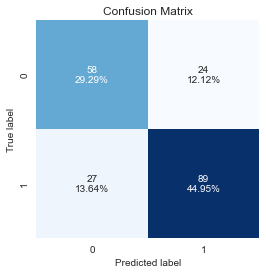

In [50]:
classif_score(y_test, y_pred)

## Avis sur un candidat donné

### NER (Détection des noms des candidats)

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [ ]:
tweet_sample = raw#.sample(20000)
tweet_sample.content = tweet_sample.content.apply(nlp_pipeline)

persons = []
start = 0

for stop in range(0, tweet_sample.shape[0], 512):
    output = nlp(' '.join(tweet_sample.iloc[start:stop].content.values))
    start = stop
    for entity in output:
    if entity['entity_group'] == 'PER':
        persons.append(entity['word'])
        
with open(path_directory + 'persons_em1.pickle', 'wb') as f:
    pickle.dump(persons, f)

In [ ]:
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(persons)

print(X.shape)

In [ ]:
wordcloud = WordCloud(background_color="white").generate(' '.join(persons))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Création de datasets par candidats

In [9]:
%%time
tweet_sample = raw#.sample(20000)
tweet_sample.content = tweet_sample.content.apply(nlp_pipeline)

Wall time: 31.7 s


In [44]:
nom_candidats = ['Freddy', 'Teheuira', 'Patrick', 'Alexandra', 'Cindy', 'Claude', 'Karima', 'Jade', 'Maxime', 
                  'Laurent', 'Candice', 'Sam', 'Clementine', 'Ugo', 'Namadia', 'Christelle', 'Coumba', 'Loic', 
                  'Clemence', 'Phil', 'Alix', 'Denis']

In [45]:
freddy_df = tweet_sample[tweet_sample.content.str.contains('freddy')]
tehe_df = tweet_sample[tweet_sample.content.str.contains('tehe' or 'teheuira' or 'tehura' or 'tehei' or 'tehuira')]
patrick_df = tweet_sample[tweet_sample.content.str.contains('patrick', 'pat')]
alexandra_df = tweet_sample[tweet_sample.content.str.contains('alexandra')]
cindy_df = tweet_sample[tweet_sample.content.str.contains('cindy')]
claude_df = tweet_sample[tweet_sample.content.str.contains('claude')]
karima_df = tweet_sample[tweet_sample.content.str.contains('karima')]
jade_df = tweet_sample[tweet_sample.content.str.contains('jade')]
maxime_df = tweet_sample[tweet_sample.content.str.contains('maxime')]
laurent_df = tweet_sample[tweet_sample.content.str.contains('laurent')]
candice_df = tweet_sample[tweet_sample.content.str.contains('candice')]
sam_df = tweet_sample[tweet_sample.content.str.contains('sam')]
clementine_df = tweet_sample[tweet_sample.content.str.contains('clementine')]
ugo_df = tweet_sample[tweet_sample.content.str.contains('ugo')]
namadia_df = tweet_sample[tweet_sample.content.str.contains('namadia')]
christelle_df = tweet_sample[tweet_sample.content.str.contains('christelle')]
coumba_df = tweet_sample[tweet_sample.content.str.contains('coumba')]
loic_df = tweet_sample[tweet_sample.content.str.contains('loic')]
clemence_df = tweet_sample[tweet_sample.content.str.contains('clemence')]
phil_df = tweet_sample[tweet_sample.content.str.contains('phil')]
alix_df = tweet_sample[tweet_sample.content.str.contains('alix')]
denis_df = tweet_sample[tweet_sample.content.str.contains('denis')]

In [46]:
path_to_save = './data_jugement/em1/'

freddy_df.to_excel(path_to_save + 'freddy.xlsx')
tehe_df.to_excel(path_to_save + 'teheuira.xlsx')
patrick_df.to_excel(path_to_save + 'patrick.xlsx')
alexandra_df.to_excel(path_to_save + 'alexandra.xlsx')
cindy_df.to_excel(path_to_save + 'cindy.xlsx')
claude_df.to_excel(path_to_save + 'claude.xlsx')
karima_df.to_excel(path_to_save + 'karima.xlsx')
jade_df.to_excel(path_to_save + 'jade.xlsx')
maxime_df.to_excel(path_to_save + 'maxime.xlsx')
laurent_df.to_excel(path_to_save + 'laurent.xlsx')
candice_df.to_excel(path_to_save + 'candice.xlsx')
sam_df.to_excel(path_to_save + 'sam.xlsx')
clementine_df.to_excel(path_to_save + 'clementine.xlsx')
ugo_df.to_excel(path_to_save + 'ugo.xlsx')
namadia_df.to_excel(path_to_save + 'namadia.xlsx')
christelle_df.to_excel(path_to_save + 'christelle.xlsx')
coumba_df.to_excel(path_to_save + 'coumba.xlsx')
loic_df.to_excel(path_to_save + 'loic.xlsx')
clemence_df.to_excel(path_to_save + 'clemence.xlsx')
phil_df.to_excel(path_to_save + 'phil.xlsx')
alix_df.to_excel(path_to_save + 'alix.xlsx')
denis_df.to_excel(path_to_save + 'denis.xlsx')

### Popularité en fonction des mentions et des réactions

In [133]:
def clean_data(df):
    
    to_return = df.drop_duplicates()
    return to_return

def simple_fame(df, nom_candidat):    
    
    data = {
        'nb_tweets':df.shape[0],
        'nb_likes':df.likeCount.sum(),
        'nb_retweets':df.retweetCount.sum(),
        'nb_not_reply':df.isReply.sum(),
#         'nb_image':df.urlImg.count()
    }
    
    return pd.DataFrame(data, index=nom_candidat)

def gen_simple_fame(nom_candidats=nom_candidats, path = './data_jugement/em1/'):
    to_return = pd.DataFrame()    
    
    for nom in nom_candidats:
        df = pd.read_excel(path + nom.lower() + '.xlsx')
        to_concat = simple_fame(clean_data(df), [nom])
        
        to_return = pd.concat([to_return, to_concat])
    return to_return

In [134]:
results = gen_simple_fame()

In [135]:
results.sort_values(by='nb_tweets', ascending=False).head(3)

,nb_tweets,nb_likes,nb_retweets,nb_not_reply
Sam,11059,335277,43617,223
Freddy,6178,157819,20865,177
Karima,5984,130254,15342,219


In [136]:
results.sort_values(by='nb_likes', ascending=False).head(3)

,nb_tweets,nb_likes,nb_retweets,nb_not_reply
Sam,11059,335277,43617,223
Teheuira,4619,187231,28428,136
Freddy,6178,157819,20865,177


In [137]:
results.sort_values(by='nb_not_reply', ascending=False).head(3)

,nb_tweets,nb_likes,nb_retweets,nb_not_reply
Claude,5344,112801,13643,331
Clemence,3977,63494,7310,331
Denis,1908,53294,6712,320


In [157]:
def gen_score_simple_fame(results):
    to_return = {}
    for nom in results.index.tolist():
        to_return[nom] = 0
    
    cols = results.columns
    for col in cols:
        to_check = results[col].sort_values()
        for ind, nom in enumerate(to_check.index): # Je regarde chaque candidat un à un
            to_return[nom] += to_check.loc[nom]
            
    return pd.DataFrame(to_return.values(), index=to_return.keys()).rename(columns={0:'score'}).sort_values(by='score', ascending=False)

In [159]:
score_simple_fame = gen_score_simple_fame(results)
score_simple_fame

,score
Sam,390176
Teheuira,220414
Freddy,185039
Karima,151799
Claude,132119
Clementine,127327
Ugo,122965
Phil,106327
Coumba,88154
Clemence,75112


In [153]:
tmp = pd.DataFrame()

pd.concat([score_simple_fame, score_simple_fame], axis=1)

,score,score
Sam,81,81
Freddy,74,74
Karima,72,72
Teheuira,71,71
Claude,70,70
Clementine,63,63
Clemence,59,59
Coumba,55,55
Ugo,54,54
Denis,52,52


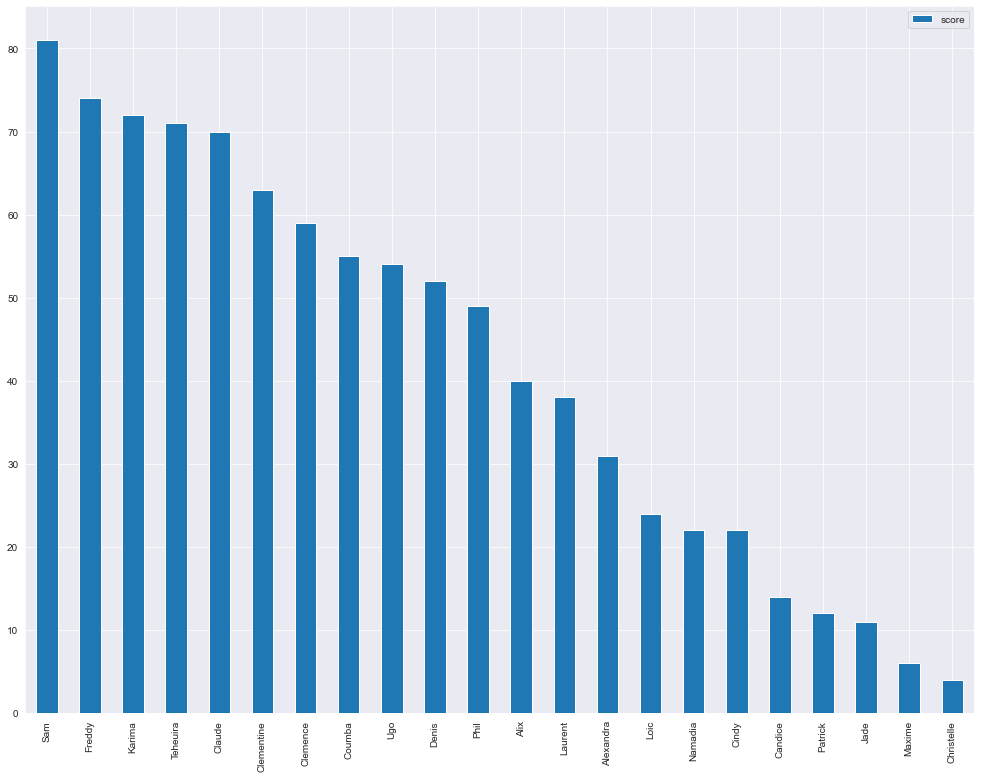

In [140]:
score_simple_fame.plot.bar()
plt.show()

### Le tweet est-il un jugement sur la personne ?

Classification binaire permettant de savoir si le tweet est un jugement sur une personne ou non.

Difficulté: 
- Parfois le jugement est ambigu: On peut rire d'un comportement d'un candidat, est ce que cela est positif ou non ?


In [43]:
df_with_name = raw[raw.content.str.contains('|'.join(nom_candidats), case=False)]
df_with_name.shape

(41260, 14)

In [47]:
print(f'{df_with_name.shape[0]}/{raw.shape[0]} tweets mentionnent/parlent d\'un candidat.')

41260/98182 tweets mentionnent/parlent d'un candidat.


In [49]:
sample = df_with_name.iloc[0:1000].content
sample.to_excel('./data_jugement/test.xlsx')

sample = df_with_name.iloc[1000:3000].content
sample.to_excel('./data_jugement/train.xlsx')

### tf-allociné

In [16]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

nlp_sentiment = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [29]:
test = freddy_df.content.sample(5, random_state=0).tolist()
test

['en train de regarder premier episode koh lanta en replay j aime pas specialement freddy but damn he is packing devant et derriere',
 "freddy j'attend son retour depuis des annees et il se tape l'epaule des la premiere epreuve jsuis degoûtee koh lanta",
 'koh lanta  degoûte pour freddy !',
 'non mais #freddy faut pas deconner !! trop degoûtee !! koh lanta ',
 'ca fait + de 10 ans on reve de revoir freddy et ça il est à deux doigts de partir bah mdrrr il a interet de vite guerir koh lanta']

In [30]:
nlp_sentiment(test)

[{'label': 'NEGATIVE', 'score': 0.6779306530952454},
 {'label': 'NEGATIVE', 'score': 0.9692743420600891},
 {'label': 'NEGATIVE', 'score': 0.9559457898139954},
 {'label': 'NEGATIVE', 'score': 0.9544665813446045},
 {'label': 'NEGATIVE', 'score': 0.52403724193573}]

#### Evaluation